# The VLITE Database Pipeline User's Guide
#### Version 2.0.0

Last updated: 05/07/2018

This guide demos `vdp`'s primary functionality and provides a few examples of how its results can be utilized.

## Basic Usage

Execution of the pipeline is controlled through a `YAML` configuration file:

In [1]:
cf = '/home/erichards/work/vdp/demo/demo_config.yaml'
with open(cf, 'r') as f:
    cfg = f.read()
    
print cfg

# vdp configuration file

stages:
                              # processing steps; yes | no  or  True | False
  source finding: yes         # extract sources from image?
  source association: yes     # match extracted sources to existing catalog?
  catalog matching: yes       # cross-match with sky survey catalogs?

options:
                              # processing options; yes | no or True | False
  save to database: yes       # save results to database?
  quality checks: yes         # run image & source count quality checks?
  overwrite: yes              # overwrite database if exists?
  reprocess: no               # redo selected stages even if done previously?
  redo match: no              # redo cross-matching with all sky catalogs?
  update match: no            # update cross-matching with new sky catalogs?

setup:
  root directory: /home/erichards/work/data/test/
  year: 2540
  month: 06
  day: [03]                   # list of days to process; [] = all
  # list files to proce

___ 

The configuration file is divided into 5 sections of key-value pairs:
* **stages** -- turns on & off stages for the pipeline to run
* **options** -- turns on & off options for the processing stages
* **setup** -- defines the path to the data and sets the database connection parameters
* **pybdsf_params** -- first two parameters are required and specify source finding mode & how much of the image to use followed by any number of desired non-default `PyBDSF` parameters
* **image_qa_params** -- sets limits for the specified image quality checks (blank will use default values); only used if the *quality_checks* option is set to ``True`` or "yes"

When the configuration file is ready, ``vdp`` can be run from the command line:
```
$ python vdp.py demo_config.yaml
```

There are additional command line options that enable removal of sources & images, removal of cross-matching results for other radio catalogs, manual addition of cross-matching results, and addition of any new catalogs to the radio catalogs database. The available command line options can be listed by invoking the "help" option with "-h" or "--help":

In [2]:
%run ../vdp.py -h

usage: vdp.py [-h] [-q] [--ignore_prompt] [--remove_catalog_matches]
              [--remove_source] [--remove_image] [--manually_add_match]
              [--add_catalog]
              config_file

Run the VLITE Database Pipline (vdp)

positional arguments:
  config_file           the YAML configuration file

optional arguments:
  -h, --help            show this help message and exit
  -q, --quiet           stops printing of messages to the console
  --ignore_prompt       ignore prompt to verify database removal/creation
  --remove_catalog_matches
                        remove matching results for the specified sky survey
                        catalog(s)
  --remove_source       removes the specified source(s) from the database
                        assoc_source table
  --remove_image        removes the specified image(s) and associated results
                        from the database entirely
  --manually_add_match  manually add catalog matching results for VLITE
                

___

## Step-by-Step Walkthrough

### Stage 0 - Connect to existing or create new database

If the *overwrite* option in the configuration file is ``True`` or "yes" and the database exists, all relations in the existing database "public" schema will be deleted and re-created. If the database does not exist, all relations will be created including the "radcat" schema which contains all the radio catalogs.

In this example, the database *demo* already exists, but I'm going to overwrite the tables to start fresh.

In [4]:
import sys
sys.path.append('../')
import vdp

In [5]:
vdp.loggerinit()

In [6]:
# read the config file
stages, opts, setup, sfparams, qaparams, dirs = vdp.cfgparse(cf)

In [7]:
# connect to the database
conn = vdp.dbinit(setup['database name'], setup['database user'], opts['overwrite'], qaparams)

Connected to database demo.
Overwriting existing database tables.


Dropping tables if they exist...
Creating new tables...


`Python` interfaces with the `PostgreSQL` database using the `psycopg2` module. A connection to the database is created through `psycopg2` in `vdp.dbinit()`. Cursor objects created from the connection instance are used to pass SQL queries and handle all data I/O to the database. Creation of all database tables, relations, functions, and triggers are specified in functions within `database.createdb`. The database will now contain the following tables:
* **assoc_source** -- VLITE catalog; associates all VLITE detections of a source in one of four spatial resolution ranges into a single entry
* **catalog_match** -- sources from other radio sky catalogs which were successfully cross-matched with a VLITE source
* **corrected_flux** -- flux measurements for all VLITE detections corrected for primary beam response
* **detected_island** -- `PyBDSF` measured properties of islands of emission in VLITE images from which sources are fit
* **detected_source** -- `PyBDSF` measured properties from Gaussian fits of all sources detected in VLITE images
* **error** -- lookup table for meaning of 'error_ids'
* **image** -- record of VLITE image header and metadata
* **run_config** -- information about the execution of the VDP; includes the full configuration file contents for posterity
* **vlite_unique** -- keeps track of all sources unique to VLITE (i.e. no matches to other radio catalogs) and the images in which those sources were and were not detected

See the [database schema](https://docs.google.com/spreadsheets/d/e/2PACX-1vR20qGzJ7U3hFBNYZ1IUJWcFpdlOmfjQKv_8pk6aRW7BuljZ6VGNWyagHnsMVkZ6_Y9-Dl1vEwNv8Bg/pubhtml "database schema") for more information on the tables' contents and their relations to each other.

The **error** table is the only table that is populated at the time of creation. It assigns an id number to each possible reason an image could fail a quality check using the default limits or the values specified in the **image_qa_params** section of the configuration file.

In [8]:
import psycopg2
import psycopg2.extras
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [9]:
cur = conn.cursor()

##### error

In [10]:
cur.execute('SELECT * FROM error')
error_rows = cur.fetchall()
error_cols = [desc[0] for desc in cur.description]
errordf = pd.DataFrame(error_rows, columns=error_cols)
errordf

,id,reason
0,1,image missing necessary header keyword(s)
1,2,number of visibilities < 1000.0
2,3,sensitivity metric (noise x sqrt(int. time)) <= 0 or > 3000.0
3,4,beam axis ratio > 4.0
4,5,bad imaging target (NCP or planet)
5,6,problem source in image field-of-view
6,7,PyBDSF failed to process
7,8,zero sources extracted
8,9,source count metric > 10.0


In [11]:
cur.close()

The values here represent the defaults.

There is an additional part of the database, or schema, where all the other radio catalogs are stored. These tables can be accessed by prepending "radcat." to the table name in queries. This "radcat" schema and all its tables are created when creating a new database. However, they are not removed and re-created like the main tables in the "public" schema when overwriting the database. If a new radio catalog needs to be included, it can be added using the optional command line argument "--add_catalog":

In [12]:
%run ../vdp.py ../demo/demo_config.yaml --add_catalog


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/254006.log
###################################################
Connected to database demo.
Using existing database demo.
No new sky catalogs to add.


The "--add_catalog" option calls the function `radiocatalogs.radcatdb.create()` which cross-checks all the table names in the "radcat" database schema with the list of radio sky survey catalog names from the `radiocatalogs.catalogio.catalog_dict` keys. If there is a catalog in the list which does not yet have a corresponding database table, then that catalog will be read and its sources inserted into a new table of the same name. The "radcat" schema is up to date in the *demo* database. You can see all radio catalogs which are included in the "radcat" schema in the **radcat.catalogs** table:

In [13]:
cur = conn.cursor()

##### radcat.catalogs

In [14]:
cur.execute('SELECT * FROM radcat.catalogs ORDER BY id')
catalog_rows = cur.fetchall()
catalog_cols = [desc[0] for desc in cur.description]
catalogdf = pd.DataFrame(catalog_rows, columns=catalog_cols)
catalogdf

,id,name,telescope,frequency,resolution,reference
0,1,cosmos,VLA,320.0,6.0,Smolcic et al. (2014)
1,2,first,VLA,1400.0,5.0,White et al. (1997)
2,3,gleam,MWA,150.0,100.0,Hurley-Walker et al. (2017)
3,4,gpsr1,VLA,1400.0,5.0,Zoonematkermani et al. (1990)
4,5,gpsr5,VLA,5000.0,4.0,Becker et al. (1994)
5,6,lazio04,VLA,330.0,6.0,Lazio (2004)
6,7,lofar_hba,LOFAR,150.0,6.0,Williams et al. (2016)
7,8,lofar_lba,LOFAR,62.0,40.0,van Weeren et al. (2014)
8,9,lotss,LOFAR,150.0,25.0,Shimwell et al. (2017)
9,10,m31_glg04,VLA,325.0,6.0,"Gelfand, Lazio, & Gaensler (2004)"


In [15]:
cur.close()

___

### Stage 1 - Record image metadata in database

The first stage is simply reading a VLITE image and recording important metadata in the database **image** table.

**vdp** assumes that VLITE images will be FITS files located in an "Images/" subdirectory under a directory with the structure "root directory/year-month/day/" as specified in the **setup** section of the configuration file. If the *year* or *month* parameters are left empty in the configuration file, then the year, month, and day are omitted and **vdp** searches for the images in the path "root directory/Images/". Setting *day* as an empty list, [ ], will process every daily directory under the specified "year-month" directory. This means that one month of VLITE images may be processed in a single run of the pipeline. Processing more than one "year-month" directory can be accomplished by successive runs executed from a bash script (see **Batch Processing Mode** below).

Keywords are extracted from the FITS image headers and stored as attributes of objects initialized from the `database.dbclasses.Image` class. Images within a single daily directory are time sorted based on the Modified Julian Date (attribute "mjdtime") before processing.

In [16]:
# Alter stages & options so the pipeline stops after stage 1
stages = {'source finding' : False, 'source association' : False, 'catalog matching' : False}
opts = {'save to database' : True, 'quality checks' : True, 'overwrite' : False, 'reprocess' : False, 
        'redo match' : False, 'update match' : False}

In [17]:
vdp.process(conn, stages, opts, dirs, setup['files'], setup['catalogs'], sfparams, qaparams)

_______________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Adding new entry to image table.
___________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Adding new entry to image table.
_____________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Adding new entry to

With all stages turned off, but with the *save to database* option set to ``True``, the pipeline simply reads all FITS files from the specified directory, runs the pre-source finding quality checks (if that option is set to ``True``), and inserts them into the database **image** table.

In [18]:
cur = conn.cursor()

##### image

In [19]:
cur.execute('SELECT * FROM image ORDER BY id')
image_rows = cur.fetchall()
image_cols = [desc[0] for desc in cur.description]
imgdf = pd.DataFrame(image_rows, columns=image_cols)
imgdf.set_index('id', inplace=True)
imgdf

,filename,imsize,obs_ra,obs_dec,pixel_scale,object,obs_date,map_date,obs_freq,primary_freq,bmaj,bmin,bpa,noise,peak,config,nvis,mjdtime,tau_time,duration,radius,nsrc,rms_box,stage,catalogs_checked,error_id,nearest_problem,separation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits,"(1673, 1673)",202.784533,30.509155,12.905294,J1331+30,2017-07-31,2017-08-01,340.85,1.5,52.4380,52.4380,0.0,25.9249,26184.8,C,10749,57965.038947,197.0,197.0,3.0,None,None,1,None,None,Virgo A,22.8617
2,/home/erichards/work/data/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits,"(1661, 1661)",202.784533,30.509155,13.004100,1331+305,2017-07-31,2017-08-02,340.85,6.0,53.8932,53.8932,0.0,21.5510,25901.4,C,16180,57965.045868,303.0,419.0,3.0,None,None,1,None,None,Virgo A,22.8617
3,/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits,"(1682, 1682)",202.784533,30.509155,12.835750,1331+305,2017-07-31,2017-08-01,340.85,1.5,58.4006,58.4006,0.0,11.1972,26008.4,C,123760,57965.175370,2235.0,68872.0,3.0,None,None,1,None,None,Virgo A,22.8617


In [20]:
cur.close()

The 'nsrc' and 'rms_box' columns are updated after source finding and the 'catalogs_checked' column is updated after catalog matching to keep a record of which radio catalogs are checked for cross-matches. These images passed all preliminary quality checks, so their 'error_id' columns remain set to ``None``. Image quality is assessed based on header metadata. The following requirements must be met in order for the image to pass all checks:

1. the image cannot be missing necessary header keywords
2. the number of visibilites (``NVIS``) must be >= 1000
3. the image sensitivity metric, defined as noise x sqrt(int. time), must be > 0 and <= 3000 mJy/beam s^1/2
4. the ratio of the beam semi-major axis to the semi-minor axis must be <= 4
5. the imaging target cannot be a planet (with RA, Dec = 0, 0) or the NCP
6. there cannot be a known problem source in the image field-of-view

These requirements represent the default values that **vdp** uses if none are specified in the **image_qa_params** section of the configuration file. The **error** table summarizes the quality requirements and will change to reflect the values specified by the user in the configuration file *at the time of creation*. This means that if the requirements change in a subsequent run which uses the existing tables, the new requirements will NOT be reflected in the **error** table. They will be recorded in the **run_config** table, though, and are output at runtime if an image fails to pass one of the checks.

Images that do not pass one of the checks in requirements 1-5 are given an 'error_id' based on the check they failed and are aborted from all further processing. Images with a known problem source in the field-of-view are flagged, but are allowed to continue through the pipeline.

The 'error_id' column in the **image** table corresponds to a particular 'reason' as described in the **error** table. The nearest problem source and its distance in degrees to the image pointing center is also recorded in the 'nearest_problem' and 'separation' columns in the **image** table. The following bright radio sources are likely to be imaged poorly by VLITE:

* the Sun, Moon, & Jupiter
* Cassiopeia A
* Cygnus A
* Hercules A
* Perseus A (3C84)
* Taurus A
* Virgo A (M87)
* Galactic Center

___

### Stage 2 - Source finding

Sources in VLITE images are found and measured using `PyBDSF`. The **pybdsf_params** section of the configuration file allows the user to define any `PyBDSF` parameters to be used during source finding. Any parameter that is not specified, with the exception of 'rms_box' and 'rms_box_bright', is simply run with its default value as defined by `PyBDSF` (see [the PyBDSF docs](http://www.astron.nl/citt/pybdsm/process_image.html#general-reduction-parameters "PyBDSF process_image") for more details).

In [21]:
print sfparams

{'adaptive_thresh': 10.0, 'scale': 1.0, 'thresh': 'hard', 'mode': 'default', 'adaptive_rms_box': True}


The parameters *scale* and *mode* are **vdp** not `PyBDSF` parameters, and control the size of the circular region within which sources are extracted (see below) and processing mode for source finding, respectively. Currently, there are only two options for the *mode* parameter: 'default' or 'minimize_islands'. 'Default' mode just runs the image through `PyBDSF` in a single pass using the specified parameters and is the mode that should be used when processing multiple images as part of the pipeline. 'Minimize_islands' runs `PyBDSF` on an image multiple times and attempts to minimize the number of islands that it finds by incrementing the 'rms_box' size parameter up and down. This is useful when dealing with a small number of images that have lots of artifacts and a conservative approach is desired. This mode is very time consuming, so is only recommended to be used when exploring appropriate `PyBDSF` parameters for a few images.

PyBDSF operates on the full VLITE image, but sources outside a defined circular field-of-view are removed afterwards. This is done to ensure that cone search queries in the database return sources which lie in the same well-defined field-of-view as the images. The radius of the circular field is half the image size, which for VLITE is 1 degree for A cofiguration, 2 degrees for B/B+, 3 degrees for C, and 4 degrees for D. The *scale* parameter in the vdp configuration file can be used to make the field-of-view radius smaller (i.e. *scale*: 0.5 would only extract sources detected within a region 1.5 degrees in radius if the image had a full field-of-view 3 degrees in radius).

Experience has shown that it is better to specify the 'rms_box' parameter rather than leave `PyBDSF` to calculate it internally (the default option). Images with bright ray-like or stripe artifacts will fail miserably with the default option. Setting the box size to 1/10th of the image size in pixels and the step size to 1/3rd of the box size seems to help avoid identifying bright non-point-like artifacts as real emission while still capturing most of the real point sources. The 'rms_box' parameter is calculated in this way for every image run through **vdp**, unless it is explicitly specified in the configuration file. The 'rms_box_bright' parameter is also calculated for every image as 1/5th times the rms_box sizes. This parameter is used by `PyBDSF` only if 'adaptive_rms_box' is set to ``True`` in the configuration file. This tells `PyBDSF` to use the smaller box size around bright sources where there tend to be more imaging artifacts. 

In summary, the following `PyBDSF` parameters have been found to yield the best all-around results for a variety of VLITE images:
* 'thresh' = 'hard'
* 'rms_box' = (1/10 x image size, 1/3 x 1/10 x image size)
* 'adaptive_rms_box' = ``True``
* 'adaptive_thresh' = 10.0
* 'rms_box_bright' = 1/5 x ('rms_box')

In [22]:
# Alter stages & options so the pipeline stops after stage 2
stages = {'source finding' : True, 'source association' : False, 'catalog matching' : False}
opts = {'save to database' : True, 'quality checks' : True, 'overwrite' : False, 'reprocess' : False, 
        'redo match' : False, 'update match' : False}

In [23]:
vdp.process(conn, stages, opts, dirs, setup['files'], setup['catalogs'], sfparams, qaparams)

_______________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Updating existing entries in image table.
**********************
STAGE 2: SOURCE FINDNG
**********************
Extracting sources...
 -- found 36 sources in 6.75 seconds


--> Wrote ds9 region file '/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.pybdsm.srl.reg'


 -- 36/36 sources are inside the circular FOV with radius 3.0 degree(s)
Performing source count quality checks...
...image passed.
Adding detected sources to database.
Correcting all flux measurements for primary beam response.
Completed source finding on image
/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.
___________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Updating existing entries in image table.
**********************
STAGE 2: SOURCE FINDNG
**********************
Extracting sources...
 -- found 33 sources in 6.72 seconds
 -- 33/33 sources are inside the circular FOV with radius 3.0 degree(s)
Performing source count quality checks...


--> Wrote ds9 region file '/home/erichards/work/data/test/2540-06/03/Images/6GHz.1331+305.IPln1.pybdsm.srl.reg'


...image passed.
Adding detected sources to database.
Correcting all flux measurements for primary beam response.
Completed source finding on image
/home/erichards/work/data/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits.
_____________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Performing preliminary image quality checks...
...image passed.
Updating existing entries in image table.
**********************
STAGE 2: SOURCE FINDNG
**********************
Extracting sources...
 -- found 103 sources in 7.71 seconds


--> Wrote ds9 region file '/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.pybdsm.srl.reg'


 -- 98/103 sources are inside the circular FOV with radius 3.0 degree(s)
Performing source count quality checks...
...image passed.
Adding detected sources to database.
Correcting all flux measurements for primary beam response.
Completed source finding on image
/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits.


A second round of quality checks are performed on the source finding results (again, only if the *quality checks* option is ``True``) before they are inserted into the database tables. Images are flagged if `PyBDSF` failed to process it for any reason or if there were no sources extracted. Any image that takes longer than 5 minutes for `PyBDSF` to process will fail with a timeout error to avoid `PyBDSF` getting stuck trying to fit sources to large imaging artifacts. We also define a metric developed by E. Polisensky to flag images where the number of detected sources is much larger than what is expected based on source counts from the WENSS survey and the image's noise.

In addition to inserting properties of the extracted sources into the **detected_island** and **detected_source** database tables, the source list for each image is written out as a ds9 regions file. The regions files and `PyBDSF` log files can be found in the "PyBDSF/" subdirectories under the daily directory path.

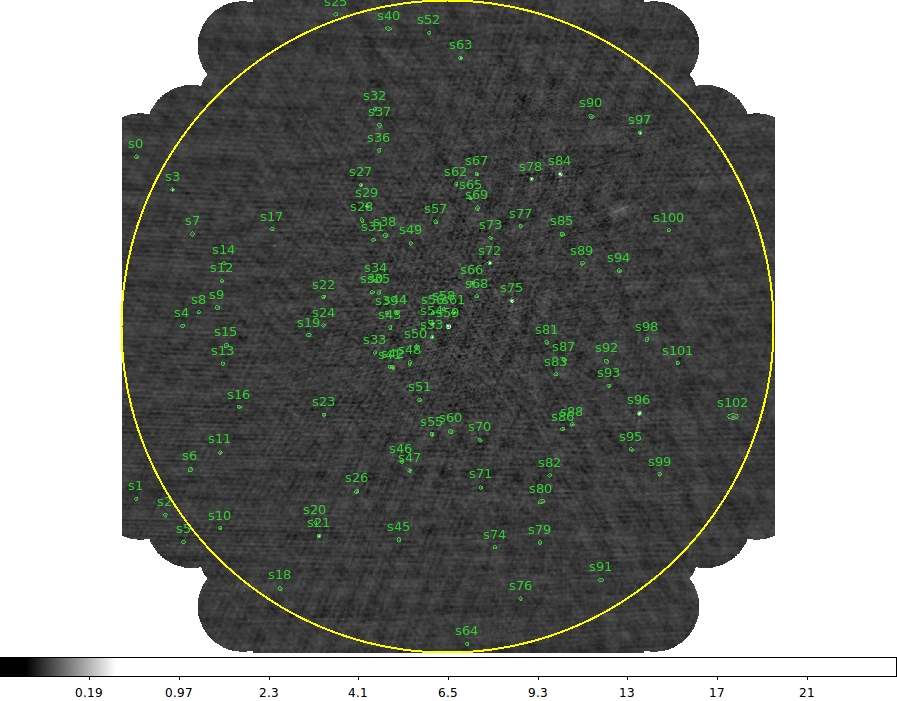

In [24]:
from IPython.display import Image
Image(filename='demo_srcs_reg.jpeg')

The example above shows the deepest of the three C configuration images processed so far of this 3C286 flux calibrator field. Only sources inside the yellow circle are recorded in the database.

The **detected_island**, **detected_source**, and **corrected_flux** database tables are populated with the source finding results. Parameters recorded in the **detected_island** and **detected_source** tables are roughly the same as what is written out from `PyBDSF`. A description of the output can be found in their [documentation](http://www.astron.nl/citt/pybdsm/write_catalog.html#definition-of-output-columns "definition of output columns"). 

The **corrected_flux** table applies a 1-D correction factor to every flux measurement from `PyBDSF` to account for the decrease in sensitivity away from the image pointing center due to the primary beam response. A 20% systematic uncertainty is also added (in quadrature) to the `PyBDSF` statistical uncertainties for every flux measurement error. This table also includes the source's angular distance from the image center in degrees and the signal-to-noise ratio (SNR) of the detection calculated as,
```
'snr' = ('peak_flux' - 'isl_mean') / 'isl_rms'.
```

In [25]:
cur = conn.cursor()

##### detected_island

In [26]:
cur.execute('SELECT * FROM detected_island LIMIT 5')
dirows = cur.fetchall()
dicols = [desc[0] for desc in cur.description]
didf = pd.DataFrame(dirows, columns=dicols)
didf

,isl_id,image_id,total_flux,e_total_flux,rms,mean,resid_rms,resid_mean
0,0,1,247.411880,27.382739,19.739594,5.163803,1.542534,5.158928
1,1,1,125.261340,20.678823,18.257141,1.503147,1.072044,1.473992
2,2,1,129.412824,23.743706,20.140693,-1.057910,1.374415,-1.048656
3,3,1,288.352130,23.168073,18.295398,4.914089,4.048069,4.657862
4,4,1,192.880161,31.954348,23.702988,-0.143795,1.611791,-0.124133


##### detected_source

In [27]:
cur.execute('SELECT * FROM detected_source LIMIT 5')
dsrows = cur.fetchall()
dscols = [desc[0] for desc in cur.description]
dsdf = pd.DataFrame(dsrows, columns=dscols)
dsdf

,src_id,isl_id,image_id,ra,e_ra,dec,e_dec,total_flux,e_total_flux,peak_flux,e_peak_flux,ra_max,e_ra_max,dec_max,e_dec_max,maj,e_maj,min,e_min,pa,e_pa,dc_maj,e_dc_maj,dc_min,e_dc_min,dc_pa,e_dc_pa,code,assoc_id
0,0,0,1,205.763448,0.000556,31.730899,0.000581,250.805119,33.903711,230.413758,20.096815,205.763448,0.000556,31.730899,0.000581,57.606836,5.269011,52.020678,4.326716,143.313221,38.302487,23.734472,5.269011,0.000000,4.326716,143.313221,38.302487,S,None
1,1,1,1,205.169468,0.000692,28.628045,0.000653,144.960458,31.815136,157.703285,17.848657,205.169468,0.000692,28.628045,0.000653,51.222781,5.899249,49.403467,5.494818,72.995180,133.051280,0.000000,5.899249,0.000000,5.494818,0.000000,133.051280,S,None
2,2,2,1,205.185293,0.000817,29.324438,0.000902,155.290522,34.763002,149.409719,20.319729,205.185293,0.000817,29.324438,0.000902,54.907353,7.663854,52.096417,6.903499,9.813301,108.383399,0.000000,7.663854,0.000000,6.903499,0.000000,108.383399,S,None
3,3,3,1,204.134280,0.000264,28.573072,0.000264,311.061916,32.034096,373.127493,17.362871,204.134280,0.000264,28.573072,0.000264,49.335846,2.370274,46.500652,2.095809,45.878644,33.727582,0.000000,2.370274,0.000000,2.095809,0.000000,33.727582,S,None
4,4,4,1,203.744159,0.001228,28.983080,0.001402,211.630484,38.973482,149.323657,24.875075,203.744159,0.001228,28.983080,0.001402,72.505740,13.677594,53.773711,7.910505,143.118712,26.946295,50.069183,13.677594,11.821299,7.910505,143.118712,26.946295,S,None


##### corrected_flux

In [28]:
cur.execute('SELECT * FROM corrected_flux LIMIT 5')
cfrows = cur.fetchall()
cfcols = [desc[0] for desc in cur.description]
cfdf = pd.DataFrame(cfrows, columns=cfcols)
cfdf

,src_id,isl_id,image_id,total_flux,e_total_flux,peak_flux,e_peak_flux,isl_total_flux,isl_e_total_flux,isl_rms,isl_mean,isl_resid_rms,isl_resid_mean,distance_from_center,snr
0,0,0,1,1436.480117,346.764926,1319.689104,287.944624,1417.045425,323.909865,113.058038,29.575553,8.834828,29.547634,2.82760,11.41110
1,1,1,1,814.329696,241.801203,885.913784,203.585654,703.667954,182.483772,102.561294,8.444078,6.022311,8.280294,2.80009,8.55556
2,2,2,1,790.041323,237.160266,760.122703,183.842890,658.388398,178.691743,102.465876,-5.382121,6.992346,-5.335042,2.39438,7.47083
3,3,3,1,1540.879248,346.631062,1848.327874,379.539412,1428.383834,307.867431,90.628256,24.342476,20.052553,23.073228,2.26431,20.12600
4,4,4,1,695.372900,189.052224,490.645876,127.709898,633.763315,164.591106,77.882994,-0.472481,5.296002,-0.407876,1.73868,6.30585


Sources can be uniquely identified and linked across these tables based on the 'src_id' and 'image_id' columns:

In [29]:
cur.execute('''SELECT ra, dec, maj, min, pa, ds.total_flux AS total_flux_meas, ds.e_total_flux AS e_total_flux_meas,
        cf.total_flux AS total_flux_corr, cf.e_total_flux AS e_total_flux_corr, distance_from_center, snr
        FROM detected_source AS ds, corrected_flux AS cf
        WHERE (ds.src_id, ds.image_id) = (cf.src_id, cf.image_id) LIMIT 1''')
vals = cur.fetchone()
cols = [desc[0] for desc in cur.description]
src_properties = dict(zip(cols, vals))
src_properties

{'dec': 31.7308988675647,
 'distance_from_center': 2.8276,
 'e_total_flux_corr': 346.764925665668,
 'e_total_flux_meas': 33.9037113241406,
 'maj': 57.6068361720226,
 'min': 52.020677990847,
 'pa': 143.313220613254,
 'ra': 205.763448043438,
 'snr': 11.4111,
 'total_flux_corr': 1436.48011675068,
 'total_flux_meas': 250.805118944319}

The **image** table is updated after source finding to keep track of the number of sources detected in the image after removing sources outside the circular field-of-view, the `PyBDSF` 'rms_box' parameter, and the highest completed stage of the pipeline, which should now be 2:

In [30]:
cur.execute('SELECT id, filename, nsrc, rms_box, stage FROM image')
updated_rows = cur.fetchall()
updated_cols = [desc[0] for desc in cur.description]
print updated_cols
for row in updated_rows:
    print row

['id', 'filename', 'nsrc', 'rms_box', 'stage']
(1, '/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits', 36, '(167, 56)', 2)
(2, '/home/erichards/work/data/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits', 33, '(166, 55)', 2)
(3, '/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits', 98, '(168, 56)', 2)


In [31]:
cur.close()

___

### Stage 3 - Source association

The association stage condenses multiple detections of a single source from different images into one entry in the **assoc_source** database table. Detections of the same source are required to be at similar spatial resolutions before being associated to avoid differences in source structure (i.e. resolved double vs. unresolved single). The resolution of an image is defined by the beam semi-minor axis size so it is less sensitive to elongated beam shapes. Currently, images are divided into four resolution classes which roughly correspond to the four VLA configurations: 
* resolution <= 15" (A or VLITE B+)
* 15" < resolution <= 35" (B)
* 35" < resolution <= 60" (C)
* resolution > 60" (D)

After source finding, the association stage proceeds as follows:
1. A cone search query is sent to the **assoc_source** table to extract all sources detected in previous images which lie in the same field-of-view as was used in source finding on the current image.
2. The extracted association candidates are then filtered on 'res_class' so that only candidates in the same resolution class as the current image remain.
3. Sources detected in the current image are cross-matched with the filtered association candidates by choosing nearest neighbors that are separated by less than half the length of the current image's beam semi-minor axis.
4. If a successful association is made, the position of the source recorded in the **assoc_source** table is updated to reflect the weighted average of all detections and the number of detections, 'ndetect', is incremented. If no association is made, those detected sources are added to the **assoc_source** table as new sources in that resolution class.
5. A new entry in the **vlite_unique** table is added for every association candidate pulled from the **assoc_source** table with no catalog matches ('nmatches' = 0) to record another VLITE detection for that source in the current image if there was a successful association or to record a non-detection for the current image if there was no association.

In [32]:
# Alter stages & options so the pipeline runs only stage 3
stages = {'source finding' : False, 'source association' : True, 'catalog matching' : False}
opts = {'save to database' : True, 'quality checks' : False, 'overwrite' : False, 'reprocess' : False, 
        'redo match' : False, 'update match' : False}

In [33]:
vdp.process(conn, stages, opts, dirs, setup['files'], setup['catalogs'], sfparams, qaparams)

_______________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Initializing image.
***************************
STAGE 3: SOURCE ASSOCIATION
***************************
Extracted 0 sources from assoc_source table within 3.0 degrees.
 -- number of matches: 0
 -- number of new sources to add: 36
Completed source association for image
/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.
___________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Initializing image.
***************************
STAGE 3: SOURCE ASSOCIATION
***************************
Extracted 36 sources from assoc_source table within 3.0 degrees.
L

All 36 sources from image 1 initially populate the **assoc_source** table and are extracted as potential matching candidates for the 33 sources in image 2. Only 28/33 sources from image 2 are successfully associated, which means that 5 new sources are added. Out of the now 41 VLITE sources, 40 are successfully associated with the 98 sources extracted from the deepest image. This results in a final count of 99 VLITE sources. This also tells us that there is 1 source that was detected in image 1 or 2, but not the deepest image 3.

In [34]:
cur = conn.cursor()

##### assoc_source

In [35]:
cur.execute('SELECT * FROM assoc_source ORDER BY id LIMIT 5')
asrows = cur.fetchall()
ascols = [desc[0] for desc in cur.description]
asdf = pd.DataFrame(asrows, columns=ascols)
asdf

,id,ra,e_ra,dec,e_dec,res_class,ndetect,nmatches
0,1,205.762356,0.000172,31.730529,0.000187,C,3,None
1,2,205.170339,0.000214,28.628344,0.000210,C,3,None
2,3,205.184798,0.000235,29.325170,0.000234,C,3,None
3,4,204.134334,0.000144,28.573185,0.000147,C,3,None
4,5,203.744227,0.000415,28.984034,0.000517,C,2,None


All detections that went into a single **assoc_source** entry can be retrieved from the **detected_source** table using the 'assoc_id' column:

In [36]:
cur.execute('SELECT * FROM detected_source WHERE assoc_id = 1 ORDER BY image_id')
detect_rows = cur.fetchall()
detect_cols = [desc[0] for desc in cur.description]
detectdf = pd.DataFrame(detect_rows, columns=detect_cols)
detectdf

,src_id,isl_id,image_id,ra,e_ra,dec,e_dec,total_flux,e_total_flux,peak_flux,e_peak_flux,ra_max,e_ra_max,dec_max,e_dec_max,maj,e_maj,min,e_min,pa,e_pa,dc_maj,e_dc_maj,dc_min,e_dc_min,dc_pa,e_dc_pa,code,assoc_id
0,0,0,1,205.763448,0.000556,31.730899,0.000581,250.805119,33.903711,230.413758,20.096815,205.763448,0.000556,31.730899,0.000581,57.606836,5.269011,52.020678,4.326716,143.313221,38.302487,23.734472,5.269011,0.0,4.326716,143.313221,38.302487,S,1
1,0,0,2,205.762866,0.000658,31.731506,0.000901,112.308544,29.402355,127.044215,16.168362,205.762866,0.000658,31.731506,0.000901,55.661471,7.817213,46.184869,5.326285,164.698553,31.536172,0.000000,7.817213,0.0,5.326285,0.000000,31.536172,S,1
2,3,3,3,205.762188,0.000188,31.730435,0.000203,278.837086,13.495895,276.509788,7.811808,205.762188,0.000188,31.730435,0.000203,59.772110,1.720178,57.610939,1.597762,2.378585,32.587127,0.000000,1.720178,0.0,1.597762,0.000000,32.587127,S,1


In [37]:
cur.close()

___

### Stage 4 -  Cross-matching other radio catalogs

All VLITE sources are cross-matched with other radio sky surveys and catalogs to help isolate transient candidates and compare fluxes across the radio spectrum. As for the association stage, cross-matching is restricted between sources with similar spatial resolutions -- the resolution of the catalog has to be in the same resolution class as the image. The resolution classes are the same as for association except the first two classes (A & B) are combined.

Cross-matching proceeds as follows:

1. The list of catalogs is filtered to remove ones outside the acceptable range of spatial resolution for the current image.
2. The 'catalogs_checked' column in the **image** table is queried to see which, if any, of the resolution-filtered catalogs have already been checked for the current image. Only new catalogs which have not yet been checked for matches are used going forward.
3. VLITE sources are cross-matched with sources from each new, resolution-filtered catalog using the same method as for association: nearest neighbors with a separation less than half the beam's semi-minor axis length.
4. If a match is successful, the id of the VLITE source in the **assoc_source** table is added to the **catalog_match** table along with the matched catalog source's id and catalog id. The number of catalog matches, 'nmatches', in the **assoc_source** table is incremented for the matched VLITE source. If no match is found, 'nmatches' is set to 0 and the **assoc_source** id & image id of the VLITE source are added to the **vlite_unique** table. The **image** table is queried to find all previously processed images with the same field-of-view as the current image which would have contained the VLITE source. New entries are added to the **vlite_unique** table for those images to record their non-detection of the VLITE source.

Which VLITE sources get forwarded for cross-matching depends on how the pipeline is being run. When following the source association stage, all new VLITE sources that are added to the **assoc_source** table for the first time are passed on for catalog cross-matching. This is so every associated VLITE source is only cross-matched with other radio catalogs once. If the existing catalog matching results need to be re-done for the current image, this can be accomplished by turning on *redo match* in the configuration file. With *redo match* set to ``True``, catalog matching results will be wiped clean for entries in the **assoc_source** table that correspond to sources detected in the current image and then re-matched with sources from the currently specified list of catalogs. It is also possible to add a new catalog to existing results without re-doing all cross-matching for all catalogs by turning on *update match* in the configuration file. If *update match* is ``True``, all entries in the **assoc_source** table that correspond to sources detected in the current image will be cross-matched against sources from any currently specified catalog for which there are not already matching results for that VLITE associated source.

The functionality to directly cross-match all sources detected in the current VLITE image with any specified radio catalogs, regardless of spatial resolution, is enabled by running only the source finding and catalog matching stages with the *save to database* option turned off. The results will be printed to the console and log file, but cannot be saved to the database. The *reprocess* option will need to be set to ``True`` if the image already has source finding results in the database. The previous results will **NOT** be deleted as long as *save to database* is ``False``.

In [38]:
# Alter stages & options so the pipeline runs only stage 4
stages = {'source finding' : False, 'source association' : True, 'catalog matching' : True}
opts = {'save to database' : True, 'quality checks' : False, 'overwrite' : False, 'reprocess' : False, 
        'redo match' : False, 'update match' : False}

In [39]:
vdp.process(conn, stages, opts, dirs, setup['files'], setup['catalogs'], sfparams, qaparams)

_______________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Initializing image.

NOTE: /home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits's
sources have already been associated with the existing VLITE catalog.
*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************
Using the following catalogs for cross-matching: ['lofar_lba', 'nrl_nvss', 'nvss', 'sumss', 'wenss']
Attempting to match 36 sources from this image to the lofar_lba sky catalog...
 -- found previous matching results for 0 sources
 -- number of matches: 0
Attempting to match 36 sources from this image to the nrl_nvss sky catalog...
 -- found previous matching results for 0 sources
 -- number of matches: 35
Attempting to match 36 sources from this image to the nvss sky cata

We can see if any of the VLITE sources failed to be matched with another radio catalog source by selecting sources from the **assoc_source** table with 'nmatches' = 0 or by querying the **vlite_unique** table:

In [40]:
cur = conn.cursor()

##### vlite_unique

In [41]:
cur.execute('SELECT * FROM vlite_unique')
vurows = cur.fetchall()
vucols = [desc[0] for desc in cur.description]
vudf = pd.DataFrame(vurows, columns=vucols)
vudf

,id,image_id,assoc_id,detected


The **vlite_unique** table is empty meaning every detected VLITE source in these three images of the 3C286 field have also been detected in NVSS and/or WENSS.

##### catalog_match

In [42]:
cur.execute('SELECT * FROM catalog_match LIMIT 5')
cmrows = cur.fetchall()
cmcols = [desc[0] for desc in cur.description]
cmdf = pd.DataFrame(cmrows, columns=cmcols)
cmdf

,id,catalog_id,src_id,assoc_id,separation
0,1,12,854281,1,1.253180
1,2,12,818653,2,3.203170
2,3,12,826627,3,1.805900
3,4,12,818019,4,0.336864
4,5,12,822770,5,4.094160


You can find all matched radio catalog sources to a VLITE source by selecting on the 'assoc_id' column:

In [43]:
cur.execute('SELECT * FROM catalog_match WHERE assoc_id = 1')
matched_cmrows = cur.fetchall()
matched_cmdf = pd.DataFrame(matched_cmrows, columns=cmcols)
matched_cmdf

,id,catalog_id,src_id,assoc_id,separation
0,1,12,854281,1,1.25318
1,37,13,1013520,1,1.24289
2,73,19,124274,1,1.86349


The 'separation' is the angular separation between source positions in arcseconds. The 'catalog_id' column in the **catalog_match** table links to the 'id' column in the **radcat.catalogs** table, and the 'src_id' column corresponds to the row id of the source in its respective catalog. 

In [44]:
cur.execute('SELECT name FROM radcat.catalogs WHERE id IN (12, 13, 19)')
print cur.fetchall()

[('nrl_nvss',), ('nvss',), ('wenss',)]


In [45]:
cur.execute('SELECT * FROM radcat.nrl_nvss WHERE id = 854281')
nrl_nvss = cur.fetchone()
cur.execute('SELECT * FROM radcat.nvss WHERE id = 1013520')
nvss = cur.fetchone()
cur.execute('SELECT * FROM radcat.wenss WHERE id = 124274')
wenss = cur.fetchone()

In [46]:
radcat_cols = [desc[0] for desc in cur.description]
radcat_rows = [nrl_nvss, nvss, wenss]

In [47]:
radcatdf = pd.DataFrame(radcat_rows, columns=radcat_cols)
radcatdf

,id,name,ra,e_ra,dec,e_dec,total_flux,e_total_flux,peak_flux,e_peak_flux,maj,e_maj,min,e_min,pa,e_pa,rms,field,catalog_id
0,854281,NRLNVSS_I1348P32_463,205.763,0.000006,31.7303,0.000007,712.198,1.2501,632.649,0.7497,49.3975,None,46.1569,None,169.711,None,NaN,I1348P32,12
1,1013520,NVSS_1013520,205.763,0.000167,31.7304,0.000167,701.800,4.4000,NaN,NaN,20.0000,None,17.6000,None,-10.700,None,NaN,C1348P32,13
2,124274,WENSS_124274,205.763,0.000417,31.7301,0.000418,2635.000,105.5000,2294.000,91.8700,102.6780,None,54.0000,None,0.000,None,3.5,None,19


In [48]:
cur.close()

___

### Summary of completed vdp run

Information about each run of the database pipeline is recorded in the **run_config** table:

In [49]:
import datetime

In [50]:
# Make up a start time for the sake of example
start_time = datetime.datetime.now() - datetime.timedelta(minutes=3)

In [51]:
nimages, exec_time = vdp.print_run_stats(start_time)

--------------------------------------
Run statistics:
Processed 12 images.
Total runtime: 0:03:01.919145


In [52]:
vdp.dbio.record_config(conn, cf, '', start_time, exec_time, nimages, stages, opts, setup, sfparams, qaparams)

In [53]:
cur = conn.cursor()

##### run_config

In [54]:
cur.execute('SELECT * FROM run_config')
cfgrows = cur.fetchall()
cfgcols = [desc[0] for desc in cur.description]
cfgdf = pd.DataFrame(cfgrows, columns=cfgcols)
cfgdf

,id,config_file,log_file,start_time,execution_time,nimages,stages,options,setup,pybdsf_params,image_qa_params
0,1,/home/erichards/work/vdp/demo/demo_config.yaml,,2018-05-07 14:51:33,00:03:01.900000,12,"{u'source finding': False, u'source association': True, u'catalog matching': True}","{u'quality checks': False, u'reprocess': False, u'update match': False, u'redo match': False, u'save to database': True, u'overwrite': False}","{u'files': [[]], u'database name': u'demo', u'catalogs': [u'cosmos', u'first', u'gleam', u'gpsr1', u'gpsr5', u'lazio04', u'lofar_hba', u'lofar_lba', u'lotss', u'm31_glg04', u'nordgc', u'nrl_nvss', u'nvss', u'sevenc', u'sumss', u'tgss', u'txs', u'vlssr', u'wenss'], u'database user': u'erichards', u'root directory': u'/home/erichards/work/data/test/', u'month': 6, u'year': 2540, u'day': [3]}","{u'adaptive_thresh': 10.0, u'scale': 1.0, u'thresh': u'hard', u'mode': u'default', u'adaptive_rms_box': True}","{u'min nvis': 1000.0, u'max sensitivity metric': 3000.0, u'max beam axis ratio': 4.0, u'max source count metric': 10.0}"


The 'nimages' column counts how many times a `database.dbclasses.Image` object was initialized for processing, which is why it is 12 in this example (3 images initialized 4 times). This number will be correct when the script is executed as a pipeline. The *stages*, *options*, *setup*, *pybdsf_params*, and *image_qa_params* columns store the contents of the configuration file as JSON key-value pairs.

In [55]:
cur.close()

___

### Extended features

#### Removing a radio catalog & its matching results

It's possible to remove all cross-matching results pertaining to a specified radio catalog by running vdp.py with the optional command line argument ``--remove_catalog_matches``:

In [56]:
# remove results for NVSS, SUMSS
%run ../vdp.py ../demo/demo_config.yaml --remove_catalog_matches


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/254006.log
###################################################
Connected to database demo.
Using existing database demo.



For which catalogs would you like to remove matching results? (List catalogs separated by a comma.)
NVSS, SUMSS


Removing matching results for NVSS, SUMSS...


In [57]:
cur = conn.cursor()

In [58]:
cur.execute('SELECT catalogs_checked FROM image')
catalogs_checked = cur.fetchall()

In [59]:
# Check that NVSS & SUMSS have been removed from the list of catalogs_checked
for row in catalogs_checked:
    print row

([u'lofar_lba', u'nrl_nvss', u'wenss'],)
([u'lofar_lba', u'nrl_nvss', u'wenss'],)
([u'lofar_lba', u'nrl_nvss', u'wenss'],)


In [60]:
cur.execute('''SELECT * FROM catalog_match WHERE catalog_id IN (
        SELECT id FROM radcat.catalogs WHERE name IN ('nvss', 'sumss'))''')
print cur.fetchall()

[]


In [61]:
cur.close()

All matching results in the **catalog_match** table have been removed for NVSS and the 'nmatches' column in the **assoc_source** table is updated accordingly.

#### Adding a new radio catalog

Adding another radio catalog without re-doing the matching for all other catalogs can be accomplished with the *update match* option in the configuration file:

In [62]:
stages = {'source finding' : False, 'source association' : False, 'catalog matching' : True}
opts = {'save to database' : True, 'quality checks' : False, 'overwrite' : False, 'reprocess' : False, 
        'redo match' : False, 'update match' : True}
setup['catalogs'] = ['NVSS', 'SUMSS']

In this example, I'll add NVSS and SUMSS back in. I chose to specify only these catalogs in the list, but I also could have left it empty so that all catalogs are checked. The pipeline looks at the list of 'catalogs_checked' in the **image** table and will ignore any catalogs that are already in that list before cross-matching.

In [63]:
vdp.process(conn, stages, opts, dirs, setup['files'], setup['catalogs'], sfparams, qaparams)

_______________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.
**********************
STAGE 1: READING IMAGE
**********************
Initializing image.
*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************
Using the following catalogs for cross-matching: ['nvss', 'sumss']
Attempting to match 36 sources from this image to the nvss sky catalog...
 -- found previous matching results for 0 sources
 -- number of matches: 36
Attempting to match 36 sources from this image to the sumss sky catalog...
 -- found previous matching results for 0 sources
 -- number of matches: 0
Completed sky catalog cross-matching for image
/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.
___________________________________________________________________________________
Starting /home/erichards/work/data/test/2540-06/03/Image

When updating the catalog matching results in this way, all sources from an image are initially extracted from the **assoc_source** table, but each source is first checked to see if it already has match results for the particular catalog in the **catalog_match** table before proceeding.

In [64]:
conn.close()

___

## Batch Processing Mode

The configuration file is set up to run one month of VLITE data at a time. To run multiple months, the pipeline must be execcuted multiple times using a bash script. I'll demonstrate this below by adding in the A, B, and D configuration images of this flux calibrator field. Each month will have its own configuration file when batch processing. In this example, I'll be using a separate configuration file for each day rather than month to demonstrate the process.

In [65]:
cf = '/home/erichards/work/vdp/demo/3c286A_config.yaml'
with open(cf, 'r') as f:
    cfg = f.read()
    
print cfg

# p3 configuration file

stages:
                              # processing steps; yes | no  or  True | False
  source finding: yes         # extract sources from image?
  source association: yes     # match extracted sources to existing catalog?
  catalog matching: yes       # cross-match with sky survey catalogs?

options:
                              # processing options; yes | no or True | False
  save to database: yes       # save results to database?
  quality checks: yes         # run image & source count quality checks?
  overwrite: no               # overwrite database if exists?
  reprocess: no               # redo selected stages even if done previously?
  redo match: no              # redo cross-matching with all sky catalogs?
  update match: no            # update cross-matching with new sky catalogs?

setup:
  root directory: /home/erichards/work/data/test/
  year: 2540
  month: 06
  day: [01]                   # list of days to process; [] = all
  # list files to proces

In reality, the *month* would be different in each of the configuration files and the list of days to process would be left empty ([ ]) so all the days in the month directory are processed.

The pipeline can now be called from a bash script. The pipeline will be executed separately for each configuration file and the output that normally prints to the console will be suppressed by setting the optional command line argument ``-q`` or ``--quiet``. Messages will be printed to a log file in the root directory with the name "yearmonth.log" for each year/month combination. If the year & month are the same, as in this case, the separate days will be appended to the existing log file.

In [66]:
with open('/home/erichards/work/vdp/demo/demo_batchvdp.sh', 'r') as f:
    batchf = f.read()
    
print batchf    

#/bin/bash

python ../vdp.py ../demo/3c286A_config.yaml -q
python ../vdp.py ../demo/3c286B_config.yaml -q
python ../vdp.py ../demo/3c286D_config.yaml -q



In this case, I am using the already existing database *demo*, so the user will not be prompted to confirm creation of a new database or to overwrite an existing one. If that is the case, though, there is an optional command line argument for the vdp.py module that allows this confirmation step to be skipped: simply add ``--ignore_prompt``. For example, if I was going to overwrite the existing database, then the first line of the bash file would have looked like this:
```
python ../vdp.py ../demo/3c286A_config.yaml -q --ignore_prompt
```

In [67]:
%%bash
bash ../demo/demo_batchvdp.sh

--> Wrote ds9 region file '/home/erichards/work/data/test/2540-06/01/Images/1.5GHz_2.J1331+3030_1.IPln1.pybdsm.srl.reg'
--> Wrote ds9 region file '/home/erichards/work/data/test/2540-06/01/Images/45GHz_2.1331+305_3.IPln1.pybdsm.srl.reg'
--> Wrote ds9 region file '/home/erichards/work/data/test/2540-06/01/Images/33GHz_2.3C286_2.IPln1.pybdsm.srl.reg'
--> Wrote ds9 region file '/home/erichards/work/data/test/2540-06/04/Images/10GHz.1331+305.IPln1.pybdsm.srl.reg'
--> Wrote ds9 region file '/home/erichards/work/data/test/2540-06/04/Images/10GHz.3C286.IPln1.pybdsm.srl.reg'
--> Wrote ds9 region file '/home/erichards/work/data/test/2540-06/02/Images/1.5GHz.1331+305.IPln1.pybdsm.srl.reg'
--> Wrote ds9 region file '/home/erichards/work/data/test/2540-06/02/Images/22GHz.3C286.IPln1.pybdsm.srl.reg'


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


In [68]:
with open('../../data/test/254006.log', 'r') as f:
    for i in range(20):
        print f.next().strip()

2018-05-07 14:19:19 vdp                         : INFO
2018-05-07 14:19:19 vdp                         : INFO   ###################################################
2018-05-07 14:19:19 vdp                         : INFO   Starting the VLITE Database Pipeline.
2018-05-07 14:19:19 vdp                         : INFO   Log file: /home/erichards/work/data/test/254006.log
2018-05-07 14:19:19 vdp                         : INFO   ###################################################
2018-05-07 14:19:19 vdp                         : INFO   Connected to database demo.
2018-05-07 14:19:19 vdp                         : INFO   Using existing database demo.
2018-05-07 14:19:19 vdp.radiocatalogs.radcatdb  : INFO   No new sky catalogs to add.
2018-05-07 14:20:39 vdp                         : INFO   _______________________________________________________________________________________
2018-05-07 14:20:39 vdp                         : INFO   Starting /home/erichards/work/data/test/2540-06/03/Images/1.5GHz

___

## Quick Analysis Examples

In [69]:
conn = psycopg2.connect(host='localhost', database='demo', user='erichards')
cur = conn.cursor()

I'm going to use SQL to extract what I want from the database tables and then load the rows into pandas dataframes for examination and analysis. It's also possible to export tables to files. For example, the **image** table can be dumped into a csv file by typing the following when in an interactive psql session:
```
demo=# \copy image to 'image_table.csv' csv;
```
Then you can use whatever tools you want to filter and analyze the data.

First, I'm going to run a couple of quick queries to make sure the database contains everything I'm expecting.

In [70]:
cur.execute('SELECT * FROM image ORDER BY id')
imgrows = cur.fetchall()
imgcols = [desc[0] for desc in cur.description]
imgdf = pd.DataFrame(imgrows, columns=imgcols)
imgdf

,id,filename,imsize,obs_ra,obs_dec,pixel_scale,object,obs_date,map_date,obs_freq,primary_freq,bmaj,bmin,bpa,noise,peak,config,nvis,mjdtime,tau_time,duration,radius,nsrc,rms_box,stage,catalogs_checked,error_id,nearest_problem,separation
0,1,/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits,"(1673, 1673)",202.784533,30.509155,12.905294,J1331+30,2017-07-31,2017-08-01,340.85,1.5,52.43800,52.43800,0.0,25.92490,26184.8,C,10749,57965.038947,197.000,197.000,3.00,36.0,"(167, 56)",4,"[lofar_lba, nrl_nvss, nvss, sumss, wenss]",NaN,Virgo A,22.8617
1,2,/home/erichards/work/data/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits,"(1661, 1661)",202.784533,30.509155,13.004100,1331+305,2017-07-31,2017-08-02,340.85,6.0,53.89320,53.89320,0.0,21.55100,25901.4,C,16180,57965.045868,303.000,419.000,3.00,33.0,"(166, 55)",4,"[lofar_lba, nrl_nvss, nvss, sumss, wenss]",NaN,Virgo A,22.8617
2,3,/home/erichards/work/data/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits,"(1682, 1682)",202.784533,30.509155,12.835750,1331+305,2017-07-31,2017-08-01,340.85,1.5,58.40060,58.40060,0.0,11.19720,26008.4,C,123760,57965.175370,2235.000,68872.000,3.00,98.0,"(168, 56)",4,"[lofar_lba, nrl_nvss, nvss, sumss, wenss]",NaN,Virgo A,22.8617
3,4,/home/erichards/work/data/test/2540-06/01/Images/1.5GHz_2.J1331+3030_1.IPln1.fits,"(5679, 5679)",202.784533,30.509155,2.535360,J1331+30,2016-12-30,2016-12-31,340.85,1.5,8.18411,8.18411,0.0,13.91960,24677.9,None,2870,57752.639143,169.998,169.998,2.00,63.0,"(568, 189)",4,"[cosmos, first, gpsr1, gpsr5, lazio04, lofar_hba, lotss, m31_glg04, nordgc, tgss]",NaN,Virgo A,22.8617
4,5,/home/erichards/work/data/test/2540-06/01/Images/45GHz_2.1331+305_3.IPln1.fits,"(5665, 5665)",202.784533,30.509155,2.541560,1331+305,2016-12-30,2016-12-31,340.85,45.0,7.53508,7.53508,0.0,8.34951,24665.6,None,8361,57752.649884,373.999,373.999,2.00,94.0,"(567, 189)",4,"[cosmos, first, gpsr1, gpsr5, lazio04, lofar_hba, lotss, m31_glg04, nordgc, tgss]",NaN,Virgo A,22.8617
5,6,/home/erichards/work/data/test/2540-06/01/Images/33GHz_2.3C286_2.IPln1.fits,"(5733, 5733)",202.784533,30.509155,2.511495,3C286,2016-12-30,2016-12-31,340.85,33.0,11.20890,11.20890,0.0,11.15540,25436.4,None,5229,57752.732998,278.003,6602.000,2.00,62.0,"(573, 191)",4,"[cosmos, first, gpsr1, gpsr5, lazio04, lofar_hba, lotss, m31_glg04, nordgc, tgss]",NaN,Virgo A,22.8617
6,7,/home/erichards/work/data/test/2540-06/04/Images/10GHz.1331+305.IPln1.fits,"(3322, 3322)",202.784533,30.509155,4.334198,1331+305,2017-09-30,2017-10-01,338.55,10.0,14.70070,14.70070,0.0,9.59455,25909.6,B,18435,58026.708530,358.997,358.997,2.00,83.0,"(332, 111)",4,"[cosmos, first, gpsr1, gpsr5, lazio04, lofar_hba, lotss, m31_glg04, nordgc, tgss]",NaN,Virgo A,22.8617
7,8,/home/erichards/work/data/test/2540-06/04/Images/10GHz.3C286.IPln1.fits,"(3391, 3391)",202.784533,30.509155,4.246276,3C286,2017-09-30,2017-10-01,338.55,10.0,14.70010,14.70010,0.0,17.16070,25979.6,B,5040,58026.950428,105.002,105.002,2.00,40.0,"(339, 113)",4,"[cosmos, first, gpsr1, gpsr5, lazio04, lofar_hba, lotss, m31_glg04, nordgc, tgss]",NaN,Virgo A,22.8617
8,9,/home/erichards/work/data/test/2540-06/02/Images/1.5GHz.1331+305.IPln1.fits,"(663, 663)",202.784533,30.509155,43.407936,1331+305,2017-05-01,2017-05-02,340.85,1.5,160.47800,160.47800,0.0,29.18220,23890.0,D,10209,57874.305451,440.004,446.003,4.00,28.0,"(66, 22)",4,"[gleam, sevenc, txs, vlssr]",NaN,Virgo A,22.8617
9,10,/home/erichards/work/data/test/2540-06/02/Images/22GHz.3C286.IPln1.fits,"(647, 647)",202.784533,30.509155,44.454024,3C286,2017-05-01,2017-05-02,340.85,22.0,153.01600,153.01600,0.0,14.37240,25387.2,D,11055,57874.319109,408.999,7387.000,3.99,41.0,"(65, 22)",4,"[gleam, sevenc, txs, vlssr]",NaN,Virgo A,22.8617


The last D config. image failed the sensitivity metric quality requirement and was not processed.

In [71]:
# These numbers should be the same
cur.execute('SELECT SUM(ndetect) FROM assoc_source WHERE nmatches = 0')
print cur.fetchone()[0]
cur.execute('SELECT COUNT(1) FROM vlite_unique WHERE detected')
print cur.fetchone()[0]

94
94


In [72]:
cur.execute('SELECT COUNT(1) FROM detected_source')
print cur.fetchone()[0]
cur.execute('SELECT COUNT(1) FROM assoc_source')
print cur.fetchone()[0]

578
308


### Extracting sources for transient candidate follow-up

Transient candidates are VLITE sources that have no counterparts in other radio catalogs. These sources are stored in the **vlite_unique** table. Each time a new detected source is added to this table, the pipeline queries the **image** table to find all images with the same field-of-view which would have contained the source. A good place to start is to see if any VLITE unique (VU) sources were detected in more than one image:

In [73]:
cur.execute('SELECT * FROM vlite_unique WHERE assoc_id IN (SELECT id FROM assoc_source WHERE ndetect > 1)')
print cur.fetchall()

[]


So, every VU source was detected only once.

Various database tables can be linked together to form a list of VU detections to follow-up:

In [74]:
cur.execute('''SELECT vu.image_id, vu.assoc_id, ds.src_id, ds.ra, ds.dec, cf.total_flux, cf.e_total_flux, 
        cf.snr, cf.distance_from_center, im.noise, im.nsrc FROM vlite_unique AS vu, detected_source AS ds, 
        corrected_flux AS cf, image AS im WHERE vu.detected AND ds.assoc_id = vu.assoc_id AND 
        (ds.src_id, ds.image_id) = (cf.src_id, cf.image_id) AND im.id = vu.image_id''')
vurows = cur.fetchall()
vucols = [desc[0] for desc in cur.description]
vudf = pd.DataFrame(vurows, columns=vucols)
vudf.head()

,image_id,assoc_id,src_id,ra,dec,total_flux,e_total_flux,snr,distance_from_center,noise,nsrc
0,4,103,5,203.762303,29.006644,232.461150,62.218391,5.16447,1.725680,13.9196,63
1,4,108,10,203.656839,31.811390,309.753925,72.316348,5.38717,1.500980,13.9196,63
2,4,112,14,203.323906,30.925179,148.348756,39.649181,4.99762,0.622968,13.9196,63
3,4,113,15,203.283317,29.261517,151.353136,48.094895,5.31712,1.320460,13.9196,63
4,4,117,19,203.094547,29.213299,237.532543,56.822917,5.45494,1.323450,13.9196,63


You can see which other images a detected VU source could have been in, but was not detected by querying the **vlite_unique** table:

In [75]:
cur.execute('''SELECT id, filename FROM image WHERE id IN (
        SELECT image_id FROM vlite_unique WHERE assoc_id = 103 AND NOT detected)''')
other_images = cur.fetchall()
for image in other_images:
    print image

(7, '/home/erichards/work/data/test/2540-06/04/Images/10GHz.1331+305.IPln1.fits')
(8, '/home/erichards/work/data/test/2540-06/04/Images/10GHz.3C286.IPln1.fits')
(5, '/home/erichards/work/data/test/2540-06/01/Images/45GHz_2.1331+305_3.IPln1.fits')
(6, '/home/erichards/work/data/test/2540-06/01/Images/33GHz_2.3C286_2.IPln1.fits')


For the sake of example, let's say that after follow-up it was determined that all 94 detected VU sources are just imaging artifacts. These sources can be removed from the database using the optional command line argument ``--remove_source``. This option will remove all specified id numbers from the **assoc_source** table. The sources are NOT removed from the **detected_source** or **corrected_flux** tables, but the 'assoc_id' column of the affected sources will be set to -1 to indicate its entry in the **assoc_source** table has been removed.

In [76]:
# Make a list of source ids to remove
cur.execute('SELECT id FROM assoc_source WHERE nmatches = 0')
rows = cur.fetchall()
assoc_ids = [row[0] for row in rows]

In [77]:
print len(assoc_ids)

94


In [78]:
print assoc_ids[:5]

[214, 215, 216, 217, 218]


In [79]:
with open('../demo/sources_to_remove.txt', 'w') as f:
    for asid in assoc_ids:
        f.write('%i\n' % asid)

In [80]:
%run ../vdp.py ../demo/demo_config.yaml --remove_source


###################################################
Starting the VLITE Database Pipeline.
Log file: /home/erichards/work/data/test/254006.log
###################################################
Connected to database demo.
Using existing database demo.



Please enter the id number(s) (i.e. 1, 2, 3) of the source(s) you wish to remove from the database assoc_source table, or provide a text file with one id number per line:
../demo/sources_to_remove.txt


Removing row(s) [214, 215, 216, 217, 218, 219, 220, 221, 222, 249, 252, 103, 253, 254, 255, 108, 256, 257, 258, 259, 261, 262, 263, 265, 267, 268, 112, 113, 270, 272, 117, 123, 129, 130, 138, 142, 143, 145, 149, 153, 156, 157, 226, 227, 232, 233, 235, 237, 239, 240, 241, 276, 245, 246, 247, 164, 166, 167, 168, 171, 172, 279, 281, 282, 285, 286, 287, 288, 293, 296, 174, 175, 176, 297, 298, 299, 300, 301, 302, 303, 189, 306, 193, 307, 197, 198, 199, 202, 204, 205, 206, 207, 209, 210] from the assoc_source table...


In [81]:
# Removal of sources cascades to the vlite_unique table which should now be empty
cur.execute('SELECT COUNT(1) FROM vlite_unique')
print cur.fetchone()[0]

0


In [82]:
cur.execute('SELECT COUNT(1) FROM detected_source WHERE assoc_id = -1')
print cur.fetchone()[0]

94


### Building a source lightcurve

Just a quick demo to show how to extract flux measurements as a function of time for a VLITE source.

In [83]:
# Pick a source with lots of detections in res_class C
cur.execute('''SELECT * FROM assoc_source WHERE ndetect = (
        SELECT MAX(ndetect) FROM assoc_source WHERE res_class='C') LIMIT 1''')
print cur.fetchone()

(9, 203.396872915674, 0.000353886786517215, 30.1315681268527, 0.000304918015989818, 'C', 3, 3)


In [84]:
# Check if that source is within 1.5 degrees of the image center and has decent SNR
cur.execute('''SELECT src_id, image_id, distance_from_center, snr FROM corrected_flux WHERE (src_id, image_id) IN (
        SELECT src_id, image_id FROM detected_source WHERE assoc_id = 9)''')
cfrows = cur.fetchall()
for row in cfrows:
    print row

(8, 1, 0.650217, 10.8145)
(10, 2, 0.651291, 6.63251)
(41, 3, 0.648788, 16.3114)


Looks good. Now make a dataframe containing flux & time info:

In [85]:
cur.execute('''SELECT a.src_id, a.image_id, a.total_flux, a.e_total_flux, a.peak_flux, a.e_peak_flux, 
        a.snr, b.mjdtime FROM corrected_flux AS a, image AS b
        WHERE a.image_id = b.id AND (a.src_id, a.image_id) IN (
        SELECT src_id, image_id FROM detected_source WHERE assoc_id = 9) ORDER BY b.mjdtime''')
cfrows = cur.fetchall()
cfcols = [desc[0] for desc in cur.description]
lcdf = pd.DataFrame(cfrows, columns=cfcols)
lcdf

,src_id,image_id,total_flux,e_total_flux,peak_flux,e_peak_flux,snr,mjdtime
0,8,1,318.666000,76.573404,298.017322,64.650593,10.81450,57965.038947
1,10,2,238.166825,66.312490,183.487369,46.680366,6.63251,57965.045868
2,41,3,264.198863,58.171550,236.254654,49.433585,16.31140,57965.175370


In [86]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

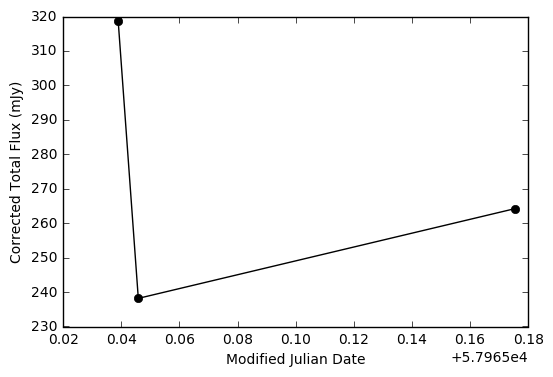

In [87]:
plt.plot(lcdf['mjdtime'], lcdf['total_flux'], '-o', c='k')
plt.xlabel('Modified Julian Date')
plt.ylabel('Corrected Total Flux (mJy)')

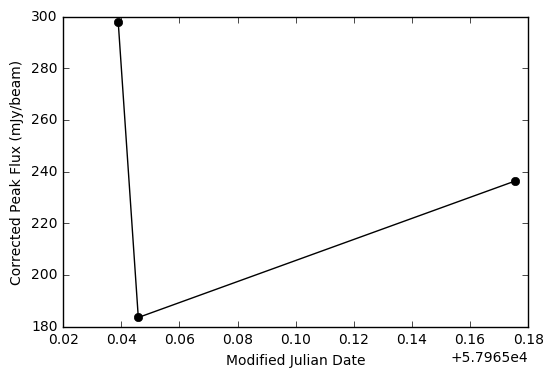

In [88]:
plt.plot(lcdf['mjdtime'], lcdf['peak_flux'], '-o', c='k')
plt.xlabel('Modified Julian Date')
plt.ylabel('Corrected Peak Flux (mJy/beam)')

### Radio spectrum

Another thing we can do is look at a source's flux as a function of frequency. Using the same source as above, I'll pick the detection with the highest SNR as the representative VLITE flux.

In [89]:
cur.execute('''SELECT a.total_flux, a.e_total_flux, a.peak_flux, a.e_peak_flux, b.obs_freq
        FROM corrected_flux AS a, image AS b WHERE (a.src_id, a.image_id) = (41, 3) AND b.id = a.image_id''')
spec_rows = cur.fetchall()
spec_cols = [desc[0] for desc in cur.description]
specdf = pd.DataFrame(spec_rows, columns=spec_cols)
specdf

,total_flux,e_total_flux,peak_flux,e_peak_flux,obs_freq
0,264.198863,58.17155,236.254654,49.433585,340.85


In [90]:
specdf['catalog'] = 'VLITE'
specdf

,total_flux,e_total_flux,peak_flux,e_peak_flux,obs_freq,catalog
0,264.198863,58.17155,236.254654,49.433585,340.85,VLITE


In [91]:
cur.execute('SELECT * FROM catalog_match WHERE assoc_id = 9')
cmrows = cur.fetchall()
cmcols = [desc[0] for desc in cur.description]

In [92]:
print cmcols
for row in cmrows:
    print row

['id', 'catalog_id', 'src_id', 'assoc_id', 'separation']
(9, 12, 836055, 9, 2.80594)
(79, 19, 122750, 9, 2.93223)
(292, 13, 1001852, 9, 2.86056)


In [93]:
cmrows.sort(key=lambda x:x[1])
cmrows

[(9, 12, 836055, 9, 2.80594),
 (292, 13, 1001852, 9, 2.86056),
 (79, 19, 122750, 9, 2.93223)]

In [94]:
cat_ids = zip(*cmrows)[1]
src_ids = zip(*cmrows)[2]

In [95]:
cat_ids

(12, 13, 19)

In [96]:
cur.execute('SELECT * FROM radcat.catalogs WHERE id IN %s',
            (cat_ids, ))
radcats = cur.fetchall()
print radcats

[(12, 'nrl_nvss', 'VLA', 1400.0, 45.0, ''), (13, 'nvss', 'VLA', 1400.0, 45.0, 'Condon et al. (1998)'), (19, 'wenss', 'WSRT', 325.0, 54.0, 'Rengelink et al. (1997)')]


In [97]:
cat_srcs = zip(radcats, src_ids)
cat_srcs

[((12, 'nrl_nvss', 'VLA', 1400.0, 45.0, ''), 836055),
 ((13, 'nvss', 'VLA', 1400.0, 45.0, 'Condon et al. (1998)'), 1001852),
 ((19, 'wenss', 'WSRT', 325.0, 54.0, 'Rengelink et al. (1997)'), 122750)]

In [98]:
# src_id
cat_srcs[0][1]

836055

In [99]:
# catalog name
cat_srcs[0][0][1]

'nrl_nvss'

In [100]:
# catalog frequency
cat_srcs[0][0][3]

1400.0

In [101]:
for cat_src in cat_srcs:
    cat = cat_src[0][1]
    srcid = cat_src[1]
    print cat, srcid

nrl_nvss 836055
nvss 1001852
wenss 122750


In [102]:
from psycopg2 import sql

In [103]:
catsrc_rows = []
for cat_src in cat_srcs:
    cat = cat_src[0][1]
    srcid = cat_src[1]
    cur.execute(psycopg2.sql.SQL('''SELECT name, total_flux, e_total_flux, peak_flux, e_peak_flux FROM radcat.{}
            WHERE id = %s''').format(psycopg2.sql.Identifier(cat)), (srcid, ))
    catsrc_rows.append(cur.fetchone())

In [104]:
catsrc_rows

[('NRLNVSS_I1330P32_208', 89.7555, 2.6593, 80.3267, 1.592),
 ('NVSS_1001852', 87.5, 3.2, None, None),
 ('WENSS_122750', 309.0, 13.31, 266.0, 11.73)]

In [105]:
catdf_rows = []
for i in range(len(catsrc_rows)):
    new_row = catsrc_rows[i] + (cat_srcs[i][0][3], cat_srcs[i][0][1])
    catdf_rows.append(new_row[1:])

catdf_rows

[(89.7555, 2.6593, 80.3267, 1.592, 1400.0, 'nrl_nvss'),
 (87.5, 3.2, None, None, 1400.0, 'nvss'),
 (309.0, 13.31, 266.0, 11.73, 325.0, 'wenss')]

In [106]:
catdf = pd.DataFrame(catdf_rows, columns=specdf.columns)
catdf

,total_flux,e_total_flux,peak_flux,e_peak_flux,obs_freq,catalog
0,89.7555,2.6593,80.3267,1.592,1400.0,nrl_nvss
1,87.5000,3.2000,NaN,NaN,1400.0,nvss
2,309.0000,13.3100,266.0000,11.730,325.0,wenss


In [107]:
allspecdf = specdf.append(catdf, ignore_index=True)
allspecdf

,total_flux,e_total_flux,peak_flux,e_peak_flux,obs_freq,catalog
0,264.198863,58.17155,236.254654,49.433585,340.85,VLITE
1,89.755500,2.65930,80.326700,1.592000,1400.00,nrl_nvss
2,87.500000,3.20000,NaN,NaN,1400.00,nvss
3,309.000000,13.31000,266.000000,11.730000,325.00,wenss


In [108]:
allspecdf.sort_values('obs_freq', inplace=True)

In [109]:
allspecdf

,total_flux,e_total_flux,peak_flux,e_peak_flux,obs_freq,catalog
3,309.000000,13.31000,266.000000,11.730000,325.00,wenss
0,264.198863,58.17155,236.254654,49.433585,340.85,VLITE
1,89.755500,2.65930,80.326700,1.592000,1400.00,nrl_nvss
2,87.500000,3.20000,NaN,NaN,1400.00,nvss


In [110]:
import numpy as np

In [111]:
# Plot the Perley & Butler (2017) fluxes for comparison
def PB17_flux(fMHz):
    f = fMHz / 1000.
    logSJy = 1.2481 - 0.4507*np.log10(f) - 0.1798*(np.log10(f))**2. + 0.0357*(np.log10(f))**3.
    logSmJy = logSJy + 3.
    return logSmJy

(0.0, 5.0)

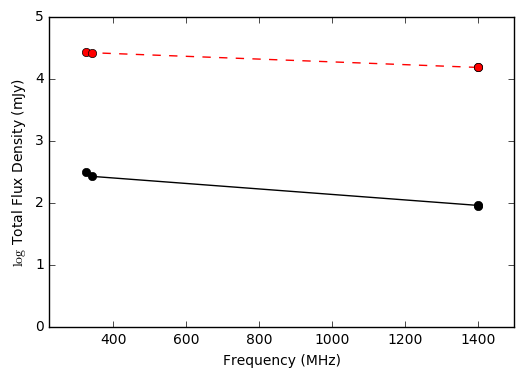

In [112]:
plt.plot(allspecdf['obs_freq'], np.log10(allspecdf['total_flux']), '-o', c='k')
plt.plot(allspecdf['obs_freq'], PB17_flux(allspecdf['obs_freq']), '--o', c='r')
plt.xlabel('Frequency (MHz)')
plt.ylabel('$\log$ Total Flux Density (mJy)')
plt.xlim(allspecdf['obs_freq'].min()-100, allspecdf['obs_freq'].max()+100)
plt.ylim(0., 5.)

The offset is probably due to the fact that the observed flux measurements are not on the Perley and Butler (2017) scale.

In [113]:
cur.close()
conn.close()